In [1]:
import torch
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import pandas as pd

import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [52]:
class Data(Dataset): 
    def __init__(self, root_dir): 
        self.root_dir = root_dir
        self.instances = sorted([
            os.path.join(self.root_dir, file) 
            for file in os.listdir(self.root_dir)
        ])
    
    def __len__(self):
        return len(self.instances)
    
    def __getitem__(self, index):

        img = Image.open(self.instances[index])

        trans_256 = transforms.Compose([transforms.Resize((256,256), 2)])
        trans_64 = transforms.Compose([transforms.Resize((64,64), 2)])

        instance = trans_64(img)
        label = trans_256(img)
        
        to_tensor = transforms.Compose([transforms.ToTensor()])
        instance = to_tensor(instance)
        label = to_tensor(label)
        
        instance = self.normalize(instance)
        label = self.normalize(label)
        
        return instance, label
    
    def normalize(self, img):
        return (img - 0.5) * 2
    
    def unnormalize(self, img):
        return img / 2 + 0.5


In [53]:

traindata=Data('DIV2K_train_LR_x8')
validdata=Data('DIV2K_valid_LR_x8')
testdata=Data('DIV2K_test_LR_x8')
BATCH_SIZE=64
trainset=DataLoader(traindata,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)
validset=DataLoader(validdata,batch_size=BATCH_SIZE,shuffle=False,num_workers=0)
testset=DataLoader(testdata,batch_size=BATCH_SIZE,shuffle=False,num_workers=0)

In [54]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.ConvTranspose2d(3,3,6,stride=4,padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        return self.model(x)

In [55]:
model = CNN()

model = model.to(device)
#model = nn.DataParallel(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

In [56]:
num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(trainset):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 64
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 64
break minibatch for-loop


In [57]:
NUM_EPOCHS=64

def totalcost(model, data_loader):
    totalcost=0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)
        output=model(features)
        totalcost += mae_loss(output,targets)
    return totalcost


start_time = time.time()
traincostlist=[]
validcostlist=[]

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(trainset):
    
        features = features.to(device)
        targets = targets.to(device)
            
        output = model(features)
        cost = mae_loss(output,targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        optimizer.step()
        
        if not batch_idx % 6:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(trainset):03d} |' 
                   f' Cost: {cost:.4f}')

    model.eval()
    with torch.set_grad_enabled(False):
        traincost=totalcost(model,trainset)
        traincostlist.append(traincost)
        validcost=totalcost(model,validset)
        validcostlist.append(validcost)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Cost: {traincost:.4f}'
              f' | Validation Cost.: {validcost:.4f}')
        
    elapsed = (time.time() - start_time)
    print(f'Time elapsed: {elapsed:.4f} sec')
  
elapsed = (time.time() - start_time)
print(f'Total Training Time: {elapsed:.4f} sec')

Epoch: 001/064 | Batch 000/013 | Cost: 0.4714
Epoch: 001/064 | Batch 006/013 | Cost: 0.4517
Epoch: 001/064 | Batch 012/013 | Cost: 0.4192
Epoch: 001/064 Train Cost: 5.6720 | Validation Cost.: 0.4539
Time elapsed: 26.5285 sec
Epoch: 002/064 | Batch 000/013 | Cost: 0.4333
Epoch: 002/064 | Batch 006/013 | Cost: 0.4514
Epoch: 002/064 | Batch 012/013 | Cost: 0.4174
Epoch: 002/064 Train Cost: 5.2650 | Validation Cost.: 0.4196
Time elapsed: 47.6127 sec
Epoch: 003/064 | Batch 000/013 | Cost: 0.4025
Epoch: 003/064 | Batch 006/013 | Cost: 0.3922
Epoch: 003/064 | Batch 012/013 | Cost: 0.3825
Epoch: 003/064 Train Cost: 4.8862 | Validation Cost.: 0.3880
Time elapsed: 68.3689 sec
Epoch: 004/064 | Batch 000/013 | Cost: 0.3793
Epoch: 004/064 | Batch 006/013 | Cost: 0.3547
Epoch: 004/064 | Batch 012/013 | Cost: 0.3686
Epoch: 004/064 Train Cost: 4.5628 | Validation Cost.: 0.3596
Time elapsed: 89.2651 sec
Epoch: 005/064 | Batch 000/013 | Cost: 0.3495
Epoch: 005/064 | Batch 006/013 | Cost: 0.3271
Epoch: 0

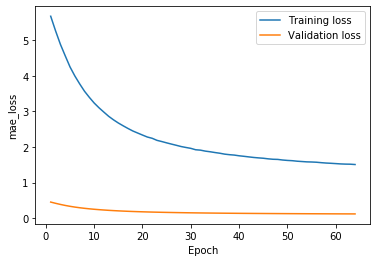

In [58]:
plt.plot(range(1, NUM_EPOCHS+1), traincostlist, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), validcostlist, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('mae_loss')
plt.xlabel('Epoch')
plt.show()

In [59]:
model.eval()
with torch.set_grad_enabled(False):
    testcost = totalcost(model, testset)
    print(f'Test cost: {testcost:.4f}')
    


Test cost: 0.1165


In [60]:
torch.save(model, 'cnnmodel')

In [61]:
print(model)

CNN(
  (model): Sequential(
    (0): ConvTranspose2d(3, 3, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (1): Tanh()
  )
)


In [62]:
instance, label = validdata[0]
output = model(instance[None, :, :, :])
output = output[0]

In [63]:
instance_img = validdata.unnormalize(instance.cpu())
label_img = validdata.unnormalize(label.cpu())
output_img = validdata.unnormalize(output.cpu())

instance_img = transforms.ToPILImage()(instance_img).convert('RGB')
label_img = transforms.ToPILImage()(label_img).convert('RGB')
output_img = transforms.ToPILImage()(output_img).convert('RGB')

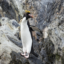

In [64]:
instance_img

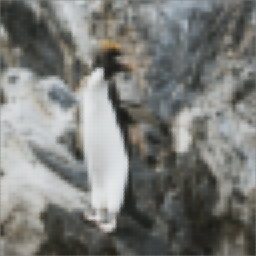

In [65]:
output_img

In [66]:
output_img.save('cnnex1.png')

In [67]:
model = CNN()

model = model.to(device)
#model = nn.DataParallel(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

In [68]:
NUM_EPOCHS=64

def totalcost(model, data_loader):
    totalcost=0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)
        output=model(features)
        totalcost += mse_loss(output,targets)
    return totalcost


start_time = time.time()
traincostlist=[]
validcostlist=[]

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(trainset):
    
        features = features.to(device)
        targets = targets.to(device)
            
        output = model(features)
        cost = mse_loss(output,targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        optimizer.step()
        
        if not batch_idx % 6:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(trainset):03d} |' 
                   f' Cost: {cost:.4f}')

    model.eval()
    with torch.set_grad_enabled(False):
        traincost=totalcost(model,trainset)
        traincostlist.append(traincost)
        validcost=totalcost(model,validset)
        validcostlist.append(validcost)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Cost: {traincost:.4f}'
              f' | Validation Cost.: {validcost:.4f}')
        
    elapsed = (time.time() - start_time)
    print(f'Time elapsed: {elapsed:.4f} sec')
  
elapsed = (time.time() - start_time)
print(f'Total Training Time: {elapsed:.4f} sec')

Epoch: 001/064 | Batch 000/013 | Cost: 0.2906
Epoch: 001/064 | Batch 006/013 | Cost: 0.2786
Epoch: 001/064 | Batch 012/013 | Cost: 0.2585
Epoch: 001/064 Train Cost: 3.4241 | Validation Cost.: 0.2788
Time elapsed: 19.3681 sec
Epoch: 002/064 | Batch 000/013 | Cost: 0.2780
Epoch: 002/064 | Batch 006/013 | Cost: 0.2248
Epoch: 002/064 | Batch 012/013 | Cost: 0.2316
Epoch: 002/064 Train Cost: 2.9808 | Validation Cost.: 0.2412
Time elapsed: 37.9392 sec
Epoch: 003/064 | Batch 000/013 | Cost: 0.2292
Epoch: 003/064 | Batch 006/013 | Cost: 0.2152
Epoch: 003/064 | Batch 012/013 | Cost: 0.1978
Epoch: 003/064 Train Cost: 2.6143 | Validation Cost.: 0.2102
Time elapsed: 56.4702 sec
Epoch: 004/064 | Batch 000/013 | Cost: 0.2015
Epoch: 004/064 | Batch 006/013 | Cost: 0.1803
Epoch: 004/064 | Batch 012/013 | Cost: 0.1756
Epoch: 004/064 Train Cost: 2.3245 | Validation Cost.: 0.1854
Time elapsed: 75.0313 sec
Epoch: 005/064 | Batch 000/013 | Cost: 0.1833
Epoch: 005/064 | Batch 006/013 | Cost: 0.1650
Epoch: 0

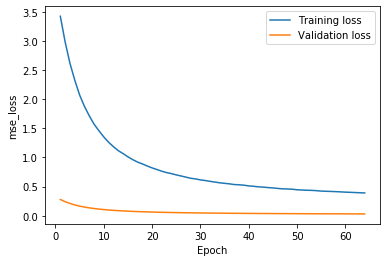

In [69]:
plt.plot(range(1, NUM_EPOCHS+1), traincostlist, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), validcostlist, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('mse_loss')
plt.xlabel('Epoch')
plt.show()

In [70]:
model.eval()
with torch.set_grad_enabled(False):
    testcost = totalcost(model, testset)
    print(f'Test cost: {testcost:.4f}')

Test cost: 0.0299


In [73]:
torch.save(model, 'cnnmodel2')
print(model)

CNN(
  (model): Sequential(
    (0): ConvTranspose2d(3, 3, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (1): Tanh()
  )
)


In [74]:
output = model(instance[None, :, :, :])
output = output[0]
output_img = validdata.unnormalize(output.cpu())
output_img = transforms.ToPILImage()(output_img).convert('RGB')
output_img.save('cnnex2.png')

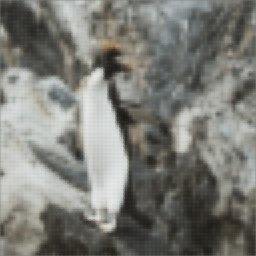

In [75]:
output_img

In [2]:
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

In [3]:
img1=Image.open('cnnex2.png')
img2=Image.open('cnnex1.png')

In [5]:

label1=Image.open('testlabel1.jpg')
trans1=transforms.Compose([transforms.ToTensor()])
temp1=trans1(img1)
tempo=trans1(label1)
temp2=trans1(img2)

print(mse_loss(temp1,tempo))
print(mse_loss(temp2,tempo))
print(mae_loss(temp1,tempo))
print(mae_loss(temp2,tempo))

tensor(0.0068)
tensor(0.0066)
tensor(0.0620)
tensor(0.0608)
